In [1]:

import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123) #setting some random seed


In [2]:
print(os.path.abspath(".")) #print current path

/content


In [3]:
annotation_folder = "/dataset/" #path to be added to current path which contains all the data
if not os.path.exists(os.path.abspath(".") + annotation_folder): #if data is not downloaded, download it into cache in /content/dataset
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774638592/2774625282 [==============================] - 67s 0us/step


In [4]:
path = "val/indoors" #Should be done also for val/outdoors to test for outdoor images !!!!

filelist = []

for root, dirs, files in os.walk(path):#
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")], #need to confirm what is mask?????
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=69) 

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data)/self.batch_size)) #no. of batches

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):#for the ceil thingie
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch) #batch is dataset? 27x10x3-batch

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )

        return x, y

In [6]:
HEIGHT = 256
WIDTH = 256
LR = 0.0005
EPOCHS = 30
BATCH_SIZE = 32

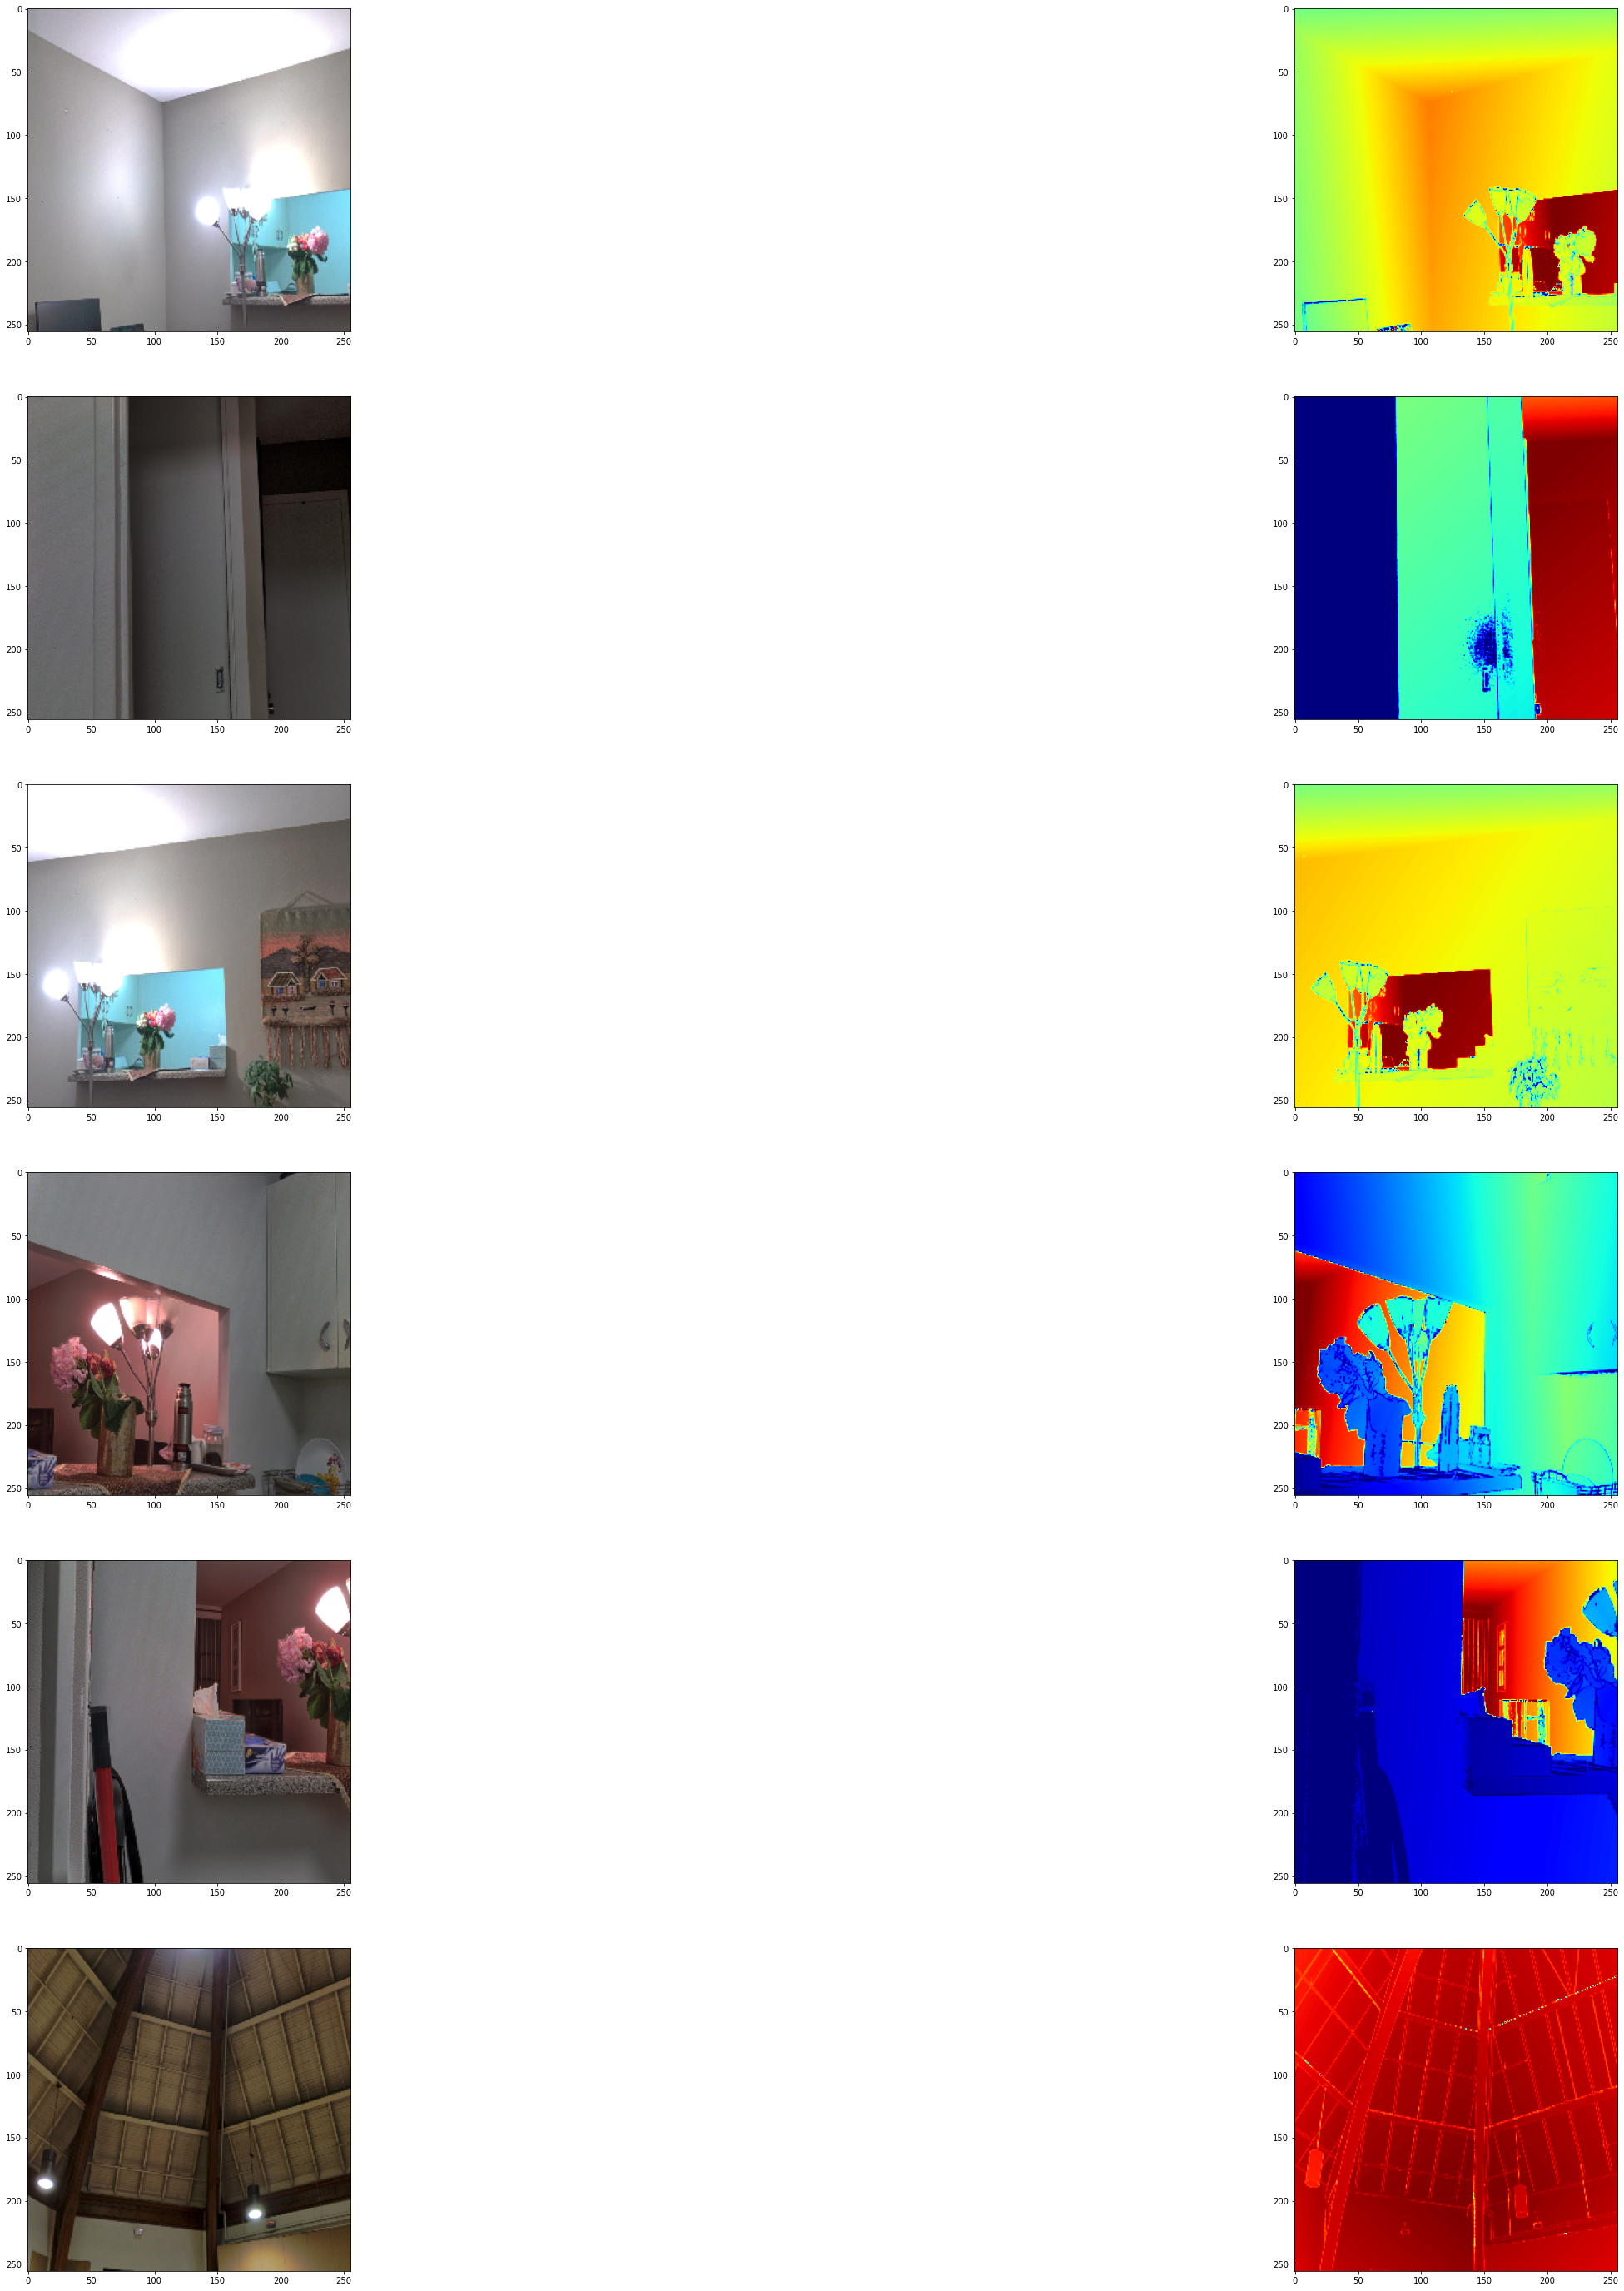

In [7]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples #input is image, and target is image which has gone thru data pipeline

    #setting up cmap (boilerplate)
    cmap = plt.cm.jet
    cmap.set_bad(color="black")#to get only rgb, no black
    

    #if test is True (also model needs to exist), prints 3 columns, input, target and prediction
    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    #if test is False(default), prints 2 coulumns, imput and target
    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
) #calling data pipeline

visualize_depth_map(visualize_samples) #as test and model are default (False/None), inputs themselves are shown, nothing predicted

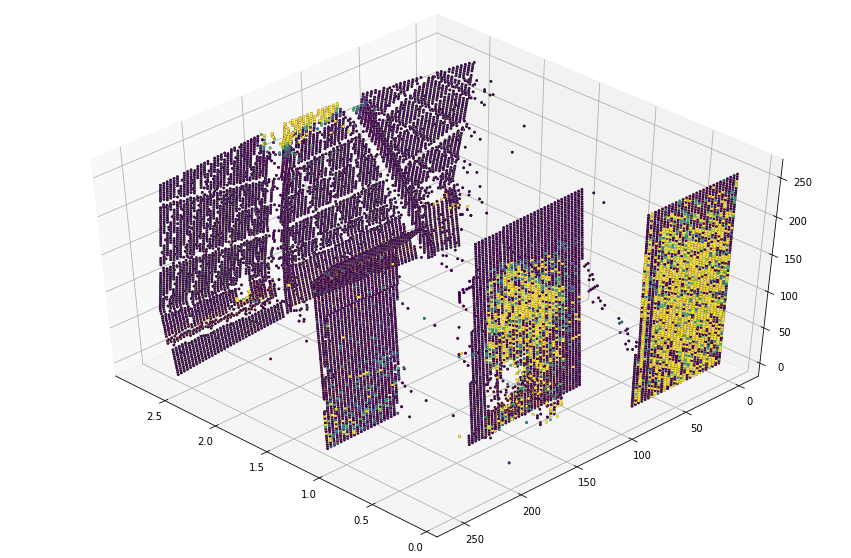

In [8]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

depth_vis1 = np.flipud(visualize_samples[1][5].squeeze())  # target
img_vis1 = np.flipud(visualize_samples[0][5].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")


STEP = 3  #every 3rd image
for x in range(0, img_vis.shape[0], STEP): #x is 0 to num_rows - 1 with a step of 3 (repeats num_rows/3 times)
    for y in range(0, img_vis.shape[1], STEP): #y is 0 to num_columns - 1 with a step of 3 (repeats num_columns/3 times)
        ax.scatter(
            [depth_vis[x, y]] * 3, #z
            [y] * 3, #y
            [x] * 3, #x
            c=tuple(img_vis[x, y, :3] / 255), #color is input(img_vis) color, average of rgb
            s=3, #sets 3d plot, default is 2
        )
    ax.view_init(45, 135) #initializing viewing angle

for x in range(0, img_vis1.shape[0], STEP): #x is 0 to num_rows - 1 with a step of 3 (repeats num_rows/3 times)
    for y in range(0, img_vis1.shape[1], STEP): #y is 0 to num_columns - 1 with a step of 3 (repeats num_columns/3 times)
        ax.scatter(
            [depth_vis1[x, y]] * 3, #z
            [y] * 3, #y
            [x] * 3, #x
            c=tuple(img_vis1[x, y, :3] / 255), #color is input(img_vis) color, average of rgb
            s=3, #sets 3d plot, default is 2
        )

    ax.view_init(45, 135) #initializing viewing angle

In [9]:
depth_vis1 = np.flipud(visualize_samples[1][5].squeeze())  # target
img_vis1 = np.flipud(visualize_samples[0][5].squeeze())  # input


for x in range(0, img_vis1.shape[0], STEP): #x is 0 to num_rows - 1 with a step of 3 (repeats num_rows/3 times)
    for y in range(0, img_vis1.shape[1], STEP): #y is 0 to num_columns - 1 with a step of 3 (repeats num_columns/3 times)
        ax.scatter(
            [depth_vis1[x, y]] * 3, #z
            [y] * 3, #y
            [x] * 3, #x
            c=tuple(img_vis1[x, y, :3] / 255), #color is input(img_vis) color, average of rgb
            s=3, #sets 3d plot, default is 2
        )

    ax.view_init(45, 135) #initializing viewing angle

In [10]:
#Defining 3 types of blocks- Downscale, Upscale and Bottleneck
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(4, 4), padding="same", strides=1, **kwargs
    ):
    # **kwargs- used to pass a keyworded, variable-length argument list; eg. first ='Geeks', mid ='for', last='Geeks'
        super().__init__(**kwargs)
        #Defining 2 convolutional neural network layers
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        #LeakyReLU- relu but instead of 0 for x<0, it returns alpha*x for x<0
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        #normalizes the inputs (mean=0, std=1)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)) 

    def call(self, input_tensor):
      #Apply convolution layer, batch normalization then relu layer- Do this twice
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d # adding the first convolution layer output tensor to the output tensor after going through all stages
        p = self.pool(x) #performing pooling on the tensor
        return x, p

In [11]:
#The upscale block contains the same layers as the Downscale block --only difference is in the upscaling and downscaling part
class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(4, 4), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x) #upsampling the images as we had downscaled while pooling
        concat = self.conc([x, skip])#why're we concatenating layers?????
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x

In [12]:
#same as the above blocks but without batch normalization or concatenating 
class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

In [14]:
#We use 3 losses- 1. Structural similarity index(SSIM). 2. L1-loss, or Point-wise depth in our case. 3. Depth smoothness loss to optimize our model

#Defining our model
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        #assigning weights to each loss- must test the model with different weights to improve performance
        self.ssim_loss_weight = 0.9
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.8
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        #Calling the downscale block with different number of layers passed as the parameter
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4]) #Calling the bottleneck block with 256 layers
        #Calling the upscale block with different number of layers passed as the parameter
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        #Returns image gradients (dy, dx) for each color channel.
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        #Defining weights for smoothness loss
        #tf.reduce_mean-Reduces input_tensor along the dimensions given in axis by computing the mean of elements across the dimensions in axis
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))# tf.exp-Computes exponential of x element-wise (though theres only one element present here)
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y
        # Depth smoothness loss
        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index loss


        #0<SSIM<1 gives the index of similarity so 1-SSIM is what we need to minimize and thus, the loss
        ssim_loss = tf.reduce_mean(
            1-tf.image.ssim(target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2)
            #k1=0.01, k2=0.03 are the default values, must tinker around with them to optimize our model
            #SSIM is less sensitivity to K2 for lower values, so it would be better if we took the values in the range of 0 < K2 < 0.4
        )
        # Point-wise depth loss
        l1_loss = tf.reduce_mean(tf.abs(target - pred))
 
        #The loss function of our model is the weighted sum of all losses
        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property #built-in function that creates and returns a property object. 
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data): #trainig the data batchwise
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True) #getting the predicted values using the selected training data
            loss = self.calculate_loss(target, pred) #calculating loss for it.

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))  
        self.loss_metric.update_state(loss)#optimizing the losses
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data): #applying on rest of the data set apart from training data 
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)  #loss for these data
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

In [15]:
#calling functions for Training the model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
) #stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=validation_loader,
) #fitting the trained model on validation dataset.

Epoch 1/30
9/9 [==============================] - 14s 964ms/step - loss: 1.0357 - val_loss: 1.7571
Epoch 2/30
9/9 [==============================] - 2s 274ms/step - loss: 0.6611 - val_loss: 1.8715
Epoch 3/30
9/9 [==============================] - 3s 290ms/step - loss: 0.4969 - val_loss: 1.8408
Epoch 4/30
9/9 [==============================] - 2s 271ms/step - loss: 0.4242 - val_loss: 1.5157
Epoch 6/30
9/9 [==============================] - 2s 261ms/step - loss: 0.3692 - val_loss: 1.4070
Epoch 7/30
9/9 [==============================] - 2s 268ms/step - loss: 0.3973 - val_loss: 0.4990
Epoch 8/30
9/9 [==============================] - 2s 270ms/step - loss: 0.3450 - val_loss: 0.3756
Epoch 9/30
9/9 [==============================] - 2s 261ms/step - loss: 0.3564 - val_loss: 0.3861
Epoch 10/30
9/9 [==============================] - 2s 266ms/step - loss: 0.3107 - val_loss: 0.4252
Epoch 11/30
9/9 [==============================] - 2s 261ms/step - loss: 0.3477 - val_loss: 0.3440
Epoch 12/30
9/9 [

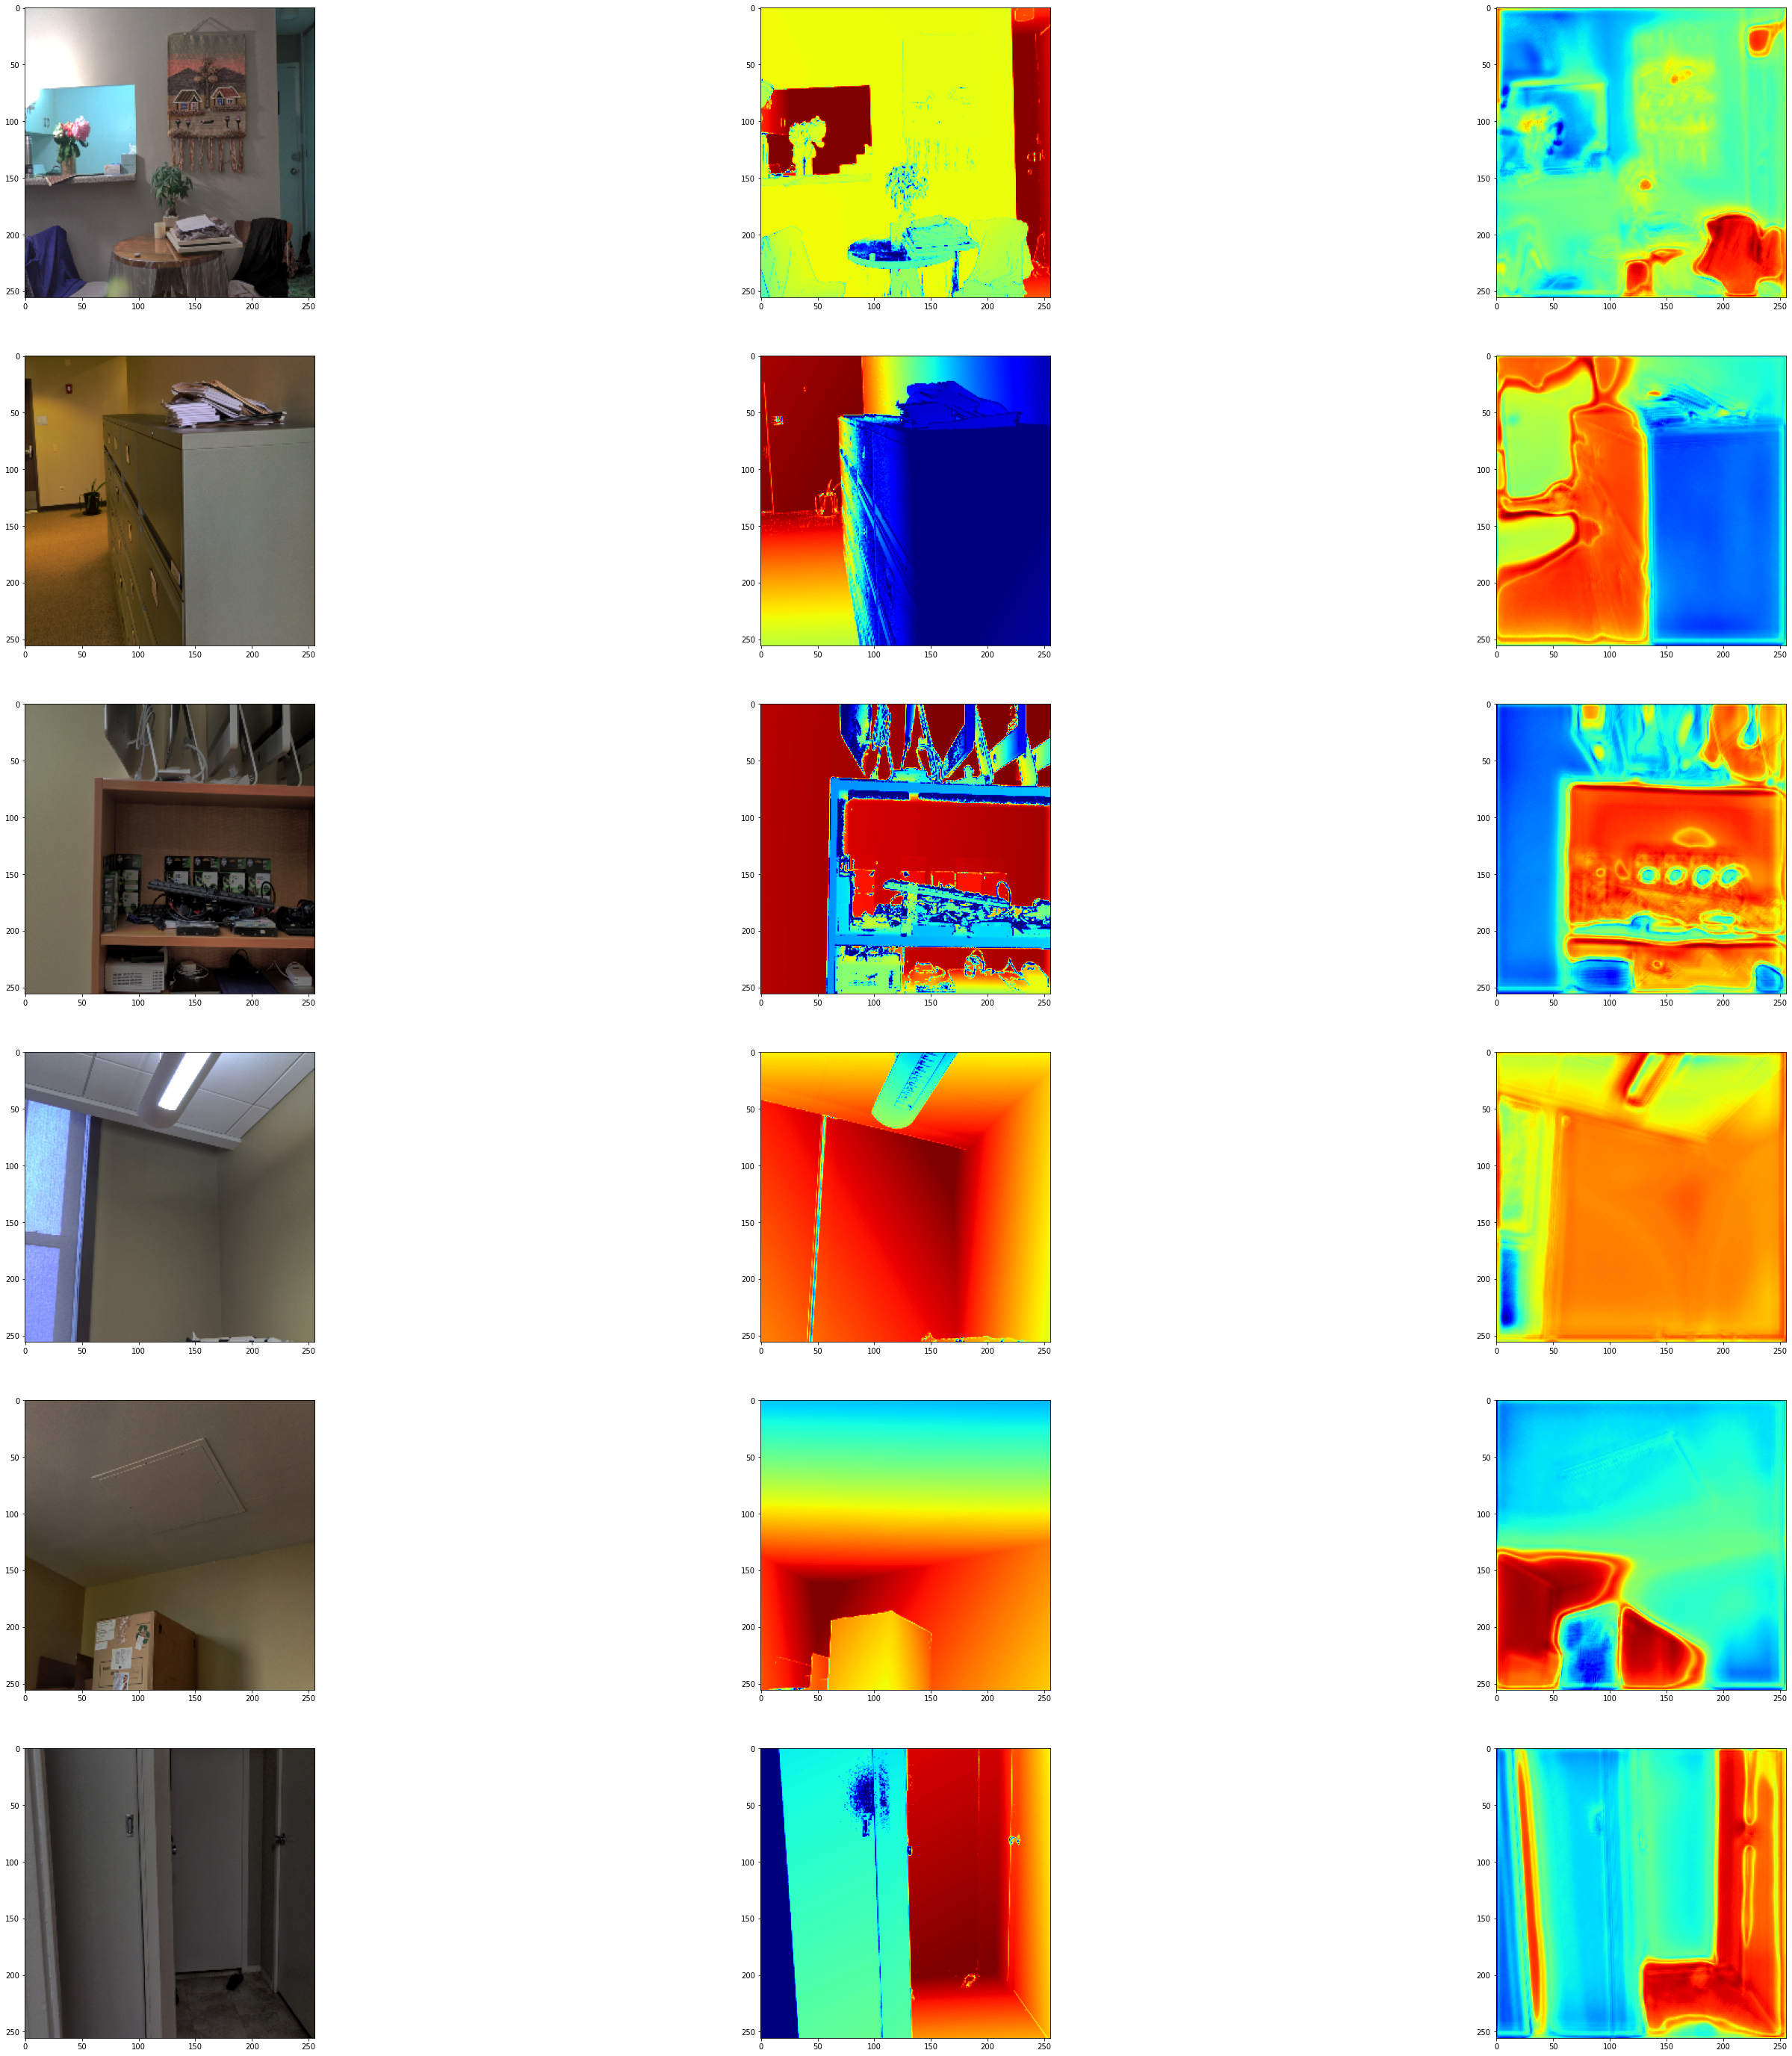

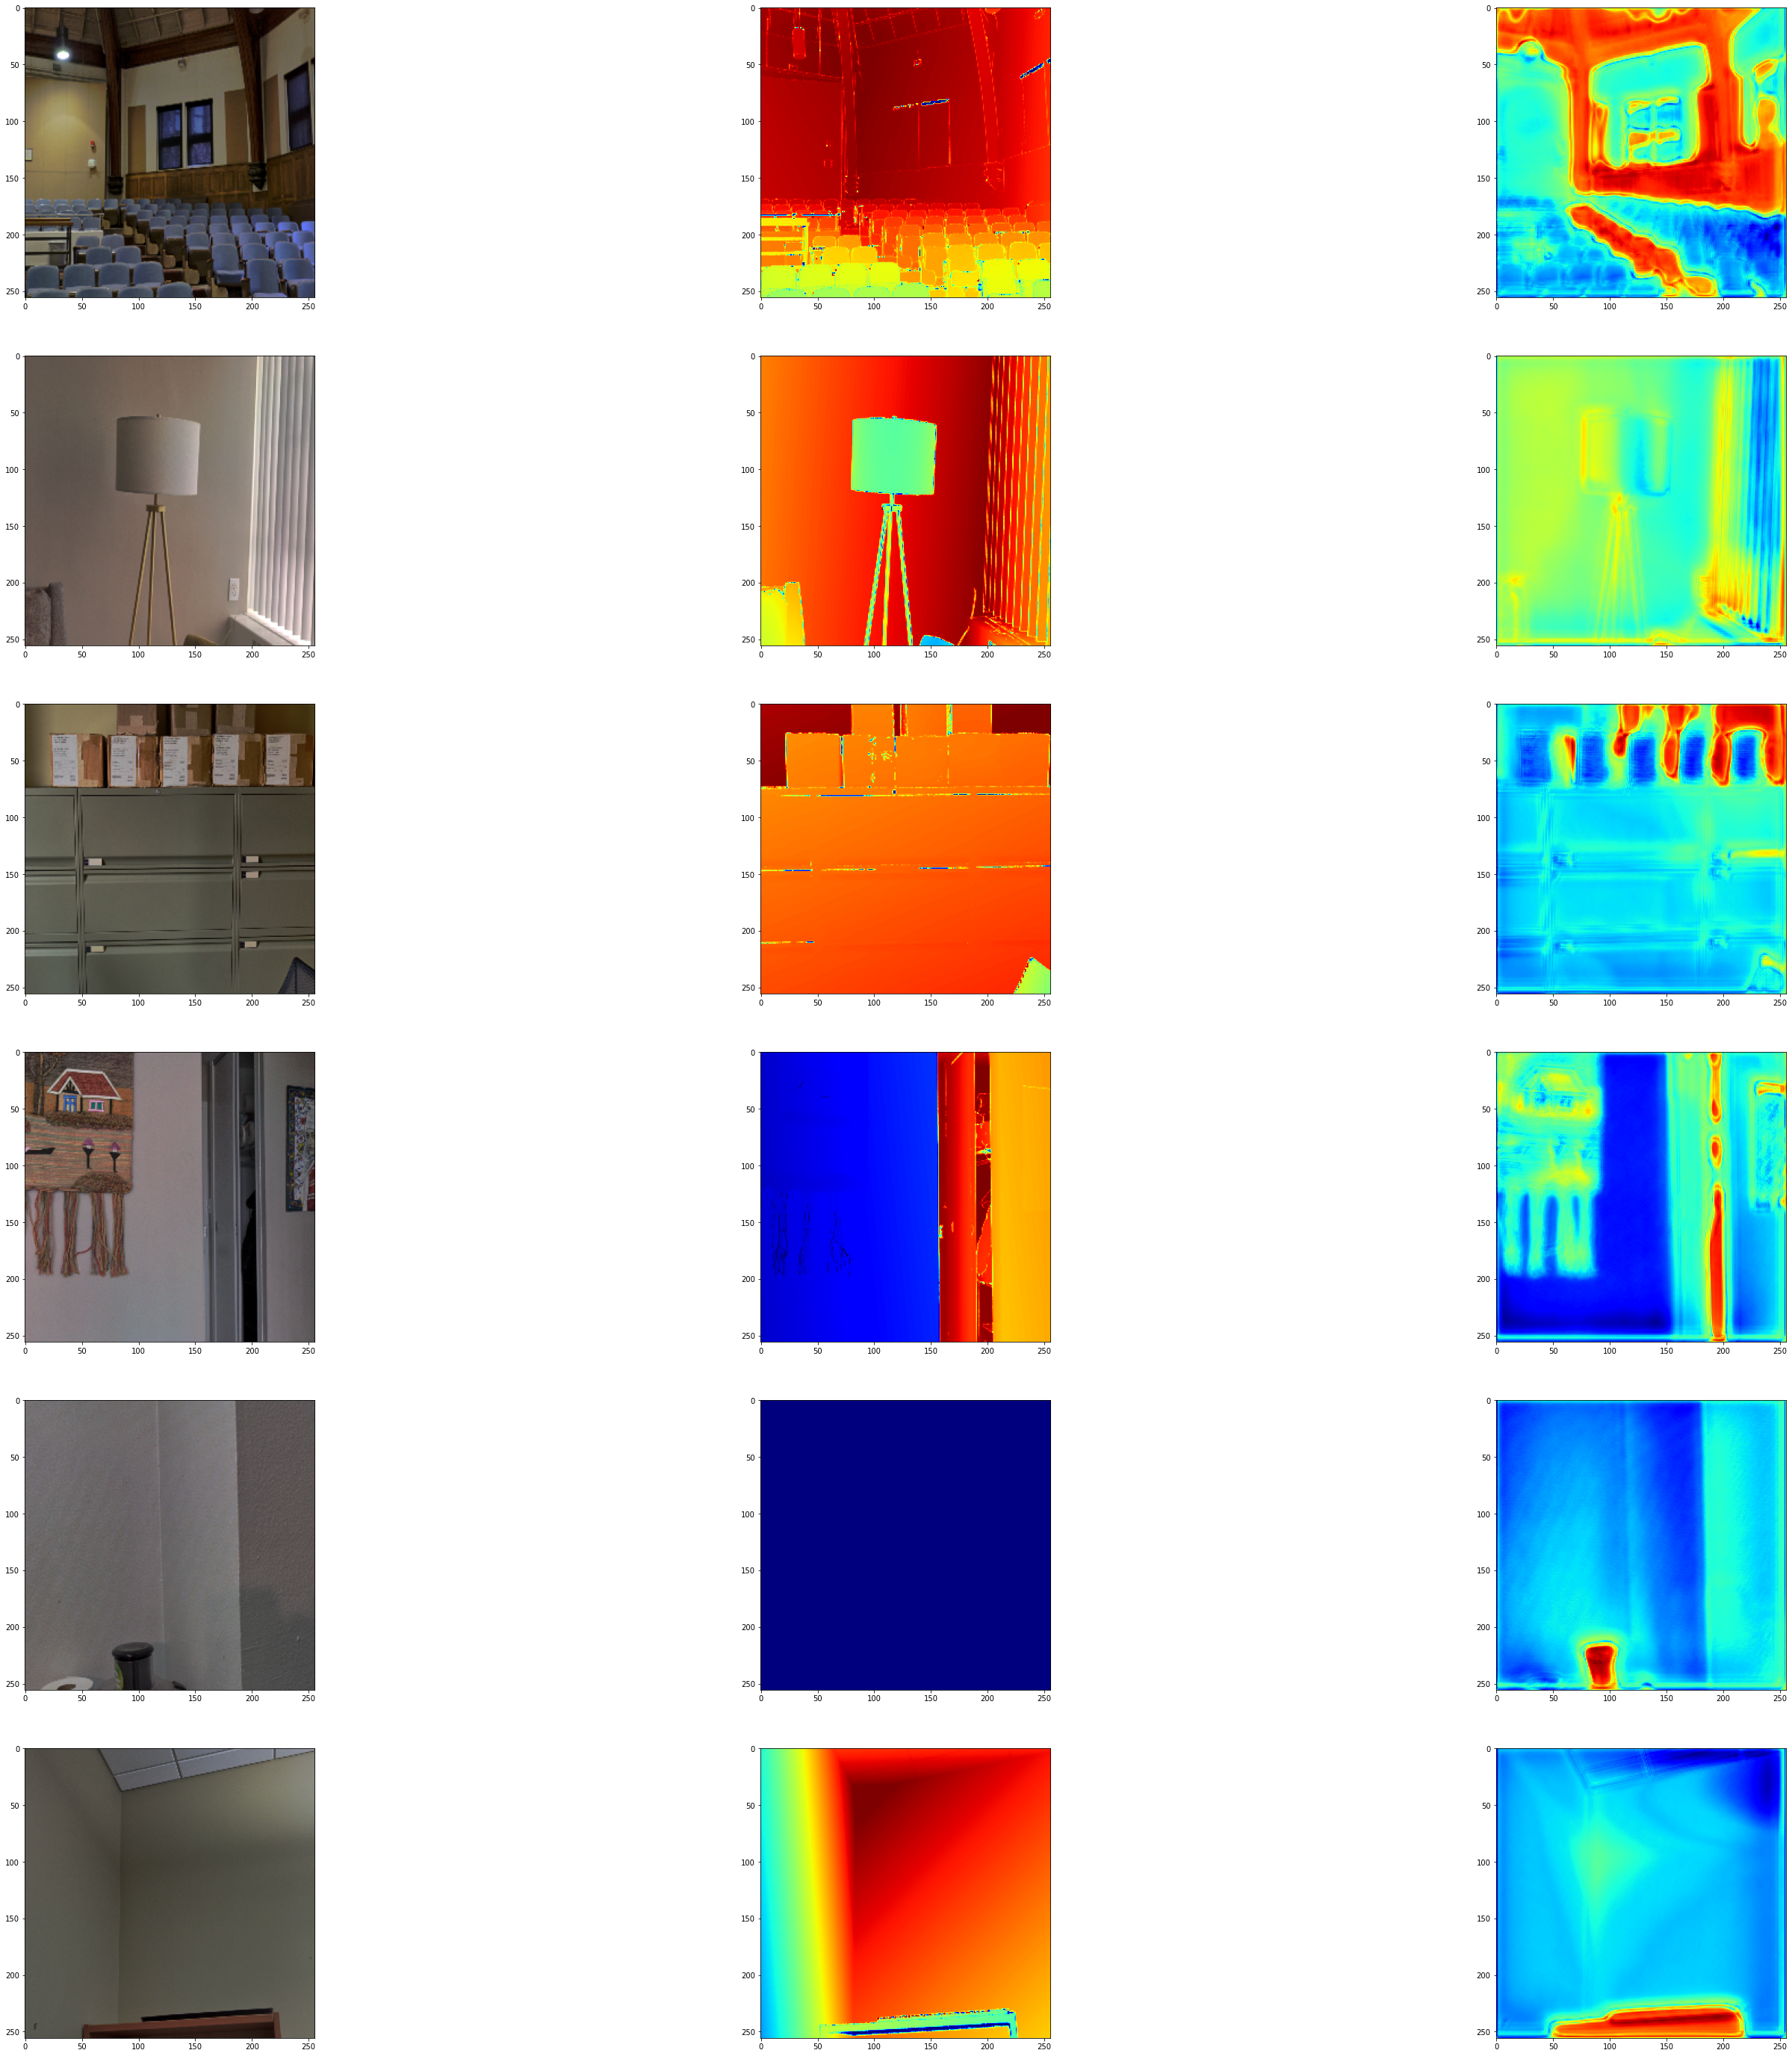

In [16]:
#visualizing the model output over the validation set
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)
#first image is the RGB image, the second image is the ground truth depth map image and the third one is the predicted depth map image.